# **Car Classification On Mobile Devices With Tensorflow 2.0**

This notebook is a submission of **[Nguyen Duc Phuong](mailto:nguyenducphuong@cfvg.org)** for the [Grab AI For Sea Challenge:](https://www.aiforsea.com/)

**Computer Vision Challenge:**  Automatically recognize car model and make using the following distint car images from the [Cars Datasets](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)

This notebook implement the **Car Classifier** with step-by-step instruction. At the end, the trained model is saved and then being used in an example Android application. The code of the mobile example app is derived from the [Tensorflow Lite example](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/android). 

![Car Classifier - Mobile Application](https://raw.githubusercontent.com/nguyenducphuong1978/CarClassifier/master/images/MobileApp.png)


Here are the steps to run the code to implement the **Car Classifier**, perform the training, save the trained model, convert the trained model to Tensorflow Lite format and import to the example Android application.

**Step 1.1: Open the notebook with Google Colab and install the Tensorflow 2.0 GPU version.**

In [0]:
#Using GPU version
#!pip install -q tensorflow-gpu==2.0.0-beta1
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 85kB/s 
     |████████████████████████████████| 419kB 45.9MB/s 
     |████████████████████████████████| 3.0MB 35.3MB/s 


In [0]:
# uncomment if you want to test with CPU
#!pip install -q tensorflow==2.0.0-alpha0

In [0]:
#Checking the Tensorflow version, should be: 2.0.0-alpha0 or 2.0.0-beta1
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [0]:
#Checking if there is GPU device
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Step 1.2:  Download the Stanford Car Images: Training and Testing Datasets**

In [0]:
#Map Google Drive to save the (Dataset) and checkpoint files
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


**Default folder: the download files are saved and extracted to /root/.keras/datasets. Update here if you want to save/extract to other (Cloud) location.**

In [0]:
import os
DIRECTORY_URL = 'http://imagenet.stanford.edu/internal/car196/'
EXTRACT_FOLDER = '/root/.keras/datasets/' 
#'/content/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset/'  #If an absolute path /path/to/file.txt is specified the file will be saved at that location.

In [0]:
#!ls -la '/root/.keras/datasets/' #EXTRACT_FOLDER

total 8
drwx------ 24 root root 4096 Jun 16 00:04 'My Drive'
drwx------  2 root root 4096 Jun 16 00:04  .Trash


In [0]:
#Download the training and testing dataset
FILE_NAMES = ['cars_train.tgz', 'cars_test.tgz']

for name in FILE_NAMES:
  fileFullPath = EXTRACT_FOLDER + name #If an absolute path /path/to/file.txt is specified the file will be saved at that location.
  if not os.path.exists(fileFullPath):
    image_dir = tf.keras.utils.get_file(fileFullPath, origin=DIRECTORY_URL+name,extract=True,cache_dir=EXTRACT_FOLDER,cache_subdir=EXTRACT_FOLDER)  


977354752/977350468 [==============================] - 283s 0us/step


In [0]:
#Display where the images dataset are saved
parent_dir = os.path.dirname(image_dir)
parent_dir

'/root/.keras/datasets'

In [0]:
#!ls -la '/root/.keras/datasets/' #/content/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset' 

total 5733020
-rw------- 1 root root     330960 Jun 16 01:33 car_devkit.tgz
drwx------ 2 root root       4096 Jun 16 01:07 car_ims
-rw------- 1 root root 1956628579 Jun 16 01:04 car_ims.tgz
-rw------- 1 root root     394471 Jun 16 01:02 cars_annos.mat
drwx------ 2 root root       4096 Dec 14  2013 cars_test
-rw------- 1 root root  977350468 Jun 16 00:56 cars_test.tgz
-rw------- 1 root root  977350468 Jun 16 00:45 cars_test.tgz.tar.gz
drwx------ 2 root root       4096 Jun 16 00:55 cars_train
-rw------- 1 root root  979269282 Jun 16 00:53 cars_train.tgz
-rw------- 1 root root  979269282 Jun 16 00:42 cars_train.tgz.tar.gz
drwx------ 2 root root       4096 Dec 14  2013 devkit


**Step 1.3: The cars' label are stored in the mat file: Download the mat and load the labels**

In [0]:
import scipy.io

#http://imagenet.stanford.edu/internal/car196/cars_annos.mat
MAT_FILE = 'cars_annos.mat'

cars_mat_file = tf.keras.utils.get_file(EXTRACT_FOLDER+MAT_FILE, origin=DIRECTORY_URL+MAT_FILE)
print(cars_mat_file)
mat = scipy.io.loadmat(cars_mat_file)
print('Cars mat file downloaded and loaded')

/root/.keras/datasets/cars_annos.mat
Cars mat file downloaded and loaded


**This function (from stackoverflow) is to print the mat file structure.  Optional step, no need to run**

In [0]:
import numpy as np
def print_mat_nested(d, indent=0, nkeys=0):
    """Pretty print nested structures from .mat files   
    Inspired by: `StackOverflow <http://stackoverflow.com/questions/3229419/pretty-printing-nested-dictionaries-in-python>`_
    """
    
    # Subset dictionary to limit keys to print.  Only works on first level
    if nkeys>0:
        d = {k: d[k] for k in list(d.keys())[:nkeys]}  # Dictionary comprehension: limit to first nkeys keys.

    if isinstance(d, dict):
        for key, value in d.items():         # iteritems loops through key, value pairs
          print (".", '\t' * indent + 'Key: ' + str(key))
          print_mat_nested(value, indent+1)

    if isinstance(d,np.ndarray) and d.dtype.names is not None:  # Note: and short-circuits by default
        for n in d.dtype.names:    # This means it's a struct, it's bit of a kludge test.
            print (".",'\t' * indent + 'Field: ' + str(n))
            print_mat_nested(d[n], indent+1)

print_mat_nested(mat, nkeys=10)

. Key: __header__
. Key: __version__
. Key: __globals__
. Key: annotations
. 	Field: relative_im_path
. 	Field: bbox_x1
. 	Field: bbox_y1
. 	Field: bbox_x2
. 	Field: bbox_y2
. 	Field: class
. 	Field: test
. Key: class_names


**Step 1.4: Load the labels and print out some values for checking**

In [0]:
annotations = mat['annotations']
images_list = annotations['relative_im_path']
annotations_class = annotations['class']

labels = mat["class_names"]

**Print sample car image, label. This step is optional**

In [0]:
print("Sample car image:")
print ("",images_list[0,15000])


print("Sample car label id = ")
print ("",annotations_class[0,15000][0,0])


print("Sample car label:")
print ("",labels[0,182])

Sample car image:
 ['car_ims/015001.jpg']
Sample car label id = 
 182
Sample car label:
 ['Suzuki SX4 Hatchback 2012']


**Display sample car image. This step is optional**

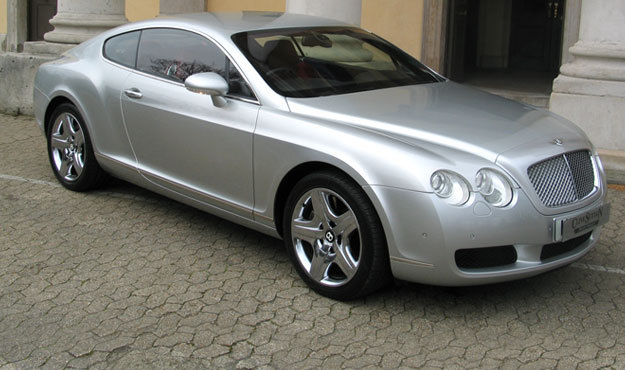

In [0]:
image_path = "/root/.keras/datasets/cars_train/01001.jpg"
import IPython.display as display
display.display(display.Image(image_path))

**Download the full file with training and testing Datasets. This step is optional. Keep for reference, later use.**

In [0]:
#Download all the images (training/testing images and annotations)
#http://imagenet.stanford.edu/internal/car196/car_ims.tgz
ALLFILE_NAMES = ['car_ims.tgz']

for name in ALLFILE_NAMES:
  image_dir = tf.keras.utils.get_file(EXTRACT_FOLDER+name, origin=DIRECTORY_URL+name,extract=True,cache_dir=EXTRACT_FOLDER,cache_subdir=EXTRACT_FOLDER)  

print("Downloaded all images to:" + image_dir)

1956634624/1956628579 [==============================] - 196s 0us/step
Downloaded all images to:/content/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset/car_ims.tgz


**This step is optional. Only run if you downloaded the car_ims.tgz**

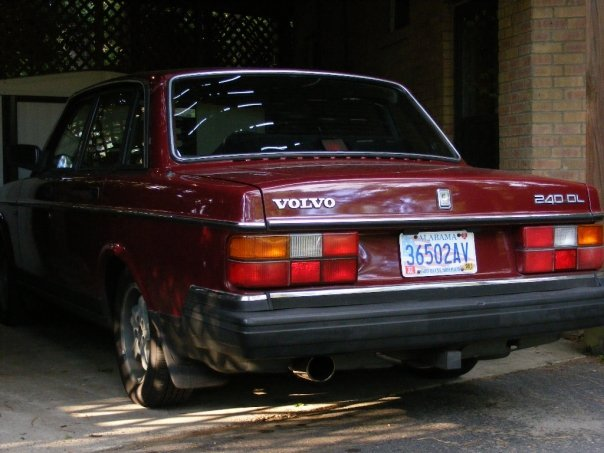

In [0]:
image_path2 = "/root/.keras/datasets/car_ims/015001.jpg"
image_path2 = "/root/.keras/datasets/car_ims/016001.jpg"
import IPython.display as display
display.display(display.Image(image_path2))

**Step 1.5: Prepare the training and testing DataSet**

**The classifier can be implemented  with base model of either [Mobinet V2](https://keras.io/applications/#mobilenetv2) or [XCeption](https://keras.io/applications/#xception) or [NASNet](https://keras.io/applications/#nasnet) or [DenseNet](https://keras.io/applications/#densenet). 
Update the constant USE_MODEL to switch the base model.**

In [0]:
USE_MODEL = 'mobinet' # mobinet or xception or nasnet or densenet

#For MobileNet V2
if USE_MODEL == 'mobinet':
  IMG_WIDTH = 224
  IMG_HEIGHT = 224
elif USE_MODEL == 'xception':
  #For XCeption model
  IMG_WIDTH = 299
  IMG_HEIGHT = 299
elif USE_MODEL == 'nasnet':
  #For NASNet model
  IMG_WIDTH = 224 # NASNet Large = 331
  IMG_HEIGHT = 224 # NASNet Large = 331
elif USE_MODEL == 'densenet':
  #For DenseNet model
  IMG_WIDTH = 224 # NASNet Large = 331
  IMG_HEIGHT = 224 # NASNet Large = 331

print ("Using as base model:" + USE_MODEL)
print(IMG_WIDTH)
print(IMG_HEIGHT)  

Using as base model:densenet
224
224


In [0]:
#Download the labels for training/testing dataset

#http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
DEVKIT_PATH = 'http://ai.stanford.edu/~jkrause/cars/'
ALLFILE_NAMES = ['car_devkit.tgz']

for name in ALLFILE_NAMES:
  image_dir = tf.keras.utils.get_file(EXTRACT_FOLDER+name, origin=DEVKIT_PATH+name,extract=True,cache_dir=EXTRACT_FOLDER,cache_subdir=EXTRACT_FOLDER)    

In [0]:
print(image_dir)

/root/.keras/datasets/car_devkit.tgz


In [0]:
#!ls -la '/root/.keras/datasets/devkit' #'/content/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset/devkit' 

total 371
-rw------- 1 root root   3177 Dec 14  2013 cars_meta.mat
-rw------- 1 root root 155831 Dec 14  2013 cars_test_annos.mat
-rw------- 1 root root 187916 Dec 14  2013 cars_train_annos.mat
-rw------- 1 root root   1248 Dec 14  2013 eval_train.m
-rw------- 1 root root   1654 Dec 14  2013 README.txt
-rw------- 1 root root  28123 Dec 14  2013 train_perfect_preds.txt


**Step 1.6: Load the mat file that contains the labels for training  dataset**

**Step 1.6.1:  Load the mat that contains labels for training/testing dataset**

In [0]:
#Load the mat that contains labels for training/testing dataset
DEVKIT_PATH = '/root/.keras/datasets/devkit/' # '/content/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset/devkit/'  #
TRAIN_MAT_FILE = 'cars_train_annos.mat'
TEST_MAT_FILE = 'cars_test_annos.mat'

import scipy.io

train_mat_file =  DEVKIT_PATH+TRAIN_MAT_FILE
train_mat = scipy.io.loadmat(train_mat_file)

test_mat_file = DEVKIT_PATH+TEST_MAT_FILE
test_mat = scipy.io.loadmat(test_mat_file)


In [0]:
print ("train mat:")
train_mat

train mat:


{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 'annotations': array([[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
         (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
         (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
         ...,
         (array([[26]], dtype=uint8), array([[246]], dtype=uint8), array([[660]], dtype=uint16), array([[449]], dtype=uint16), array([[163]], dtype=uint8), array(['08142.jpg'], dtype='<U9')),
         (array([[78]], dtype=uint8), array([[526]], dtype=uint16), 

In [0]:
print ("test mat:")
test_mat

test mat:


{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 'annotations': array([[(array([[30]], dtype=uint8), array([[52]], dtype=uint8), array([[246]], dtype=uint8), array([[147]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
         (array([[100]], dtype=uint8), array([[19]], dtype=uint8), array([[576]], dtype=uint16), array([[203]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
         (array([[51]], dtype=uint8), array([[105]], dtype=uint8), array([[968]], dtype=uint16), array([[659]], dtype=uint16), array(['00003.jpg'], dtype='<U9')),
         ...,
         (array([[33]], dtype=uint8), array([[27]], dtype=uint8), array([[602]], dtype=uint16), array([[252]], dtype=uint8), array(['08039.jpg'], dtype='<U9')),
         (array([[33]], dtype=uint8), array([[142]], dtype=uint8), array([[521]], dtype=uint16), array([[376]], dtype=uint16), array(['08040.jpg'], dtype='<U9')),
         (array([[77]],

**Step 1.6.2: Load the labels and image list**

In [0]:
#Load the labels and images file names for training and testing dataset
train_annotations_class = train_mat['annotations']['class']
train_images_list = train_mat['annotations']['fname']

test_images_list = test_mat['annotations']['fname']

print("Sample training car image:")
print (":",train_images_list[0,6000])

Sample training car image:
: ['06001.jpg']


**Display sample training car image. This step is optional**

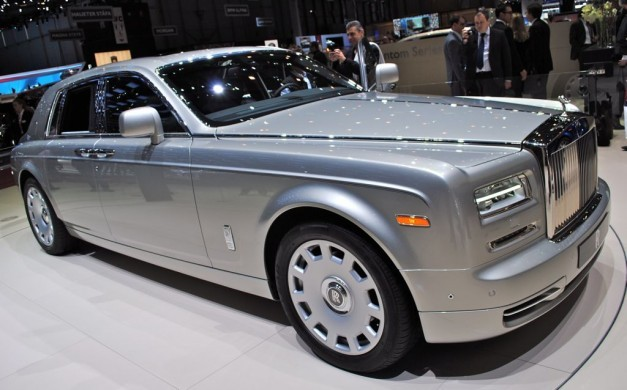

In [0]:
image_path2 = "/root/.keras/datasets/cars_train/06001.jpg"
import IPython.display as display
display.display(display.Image(image_path2))

**Step 1.7: Define helper funtions to load image files (including load, resize, jitter) and prepare the training, validation Dataset**

In [0]:
def load_image(image_file,use_keras_funcs=False):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image,channels=3) # RGB image
  if use_keras_funcs==False:
    image = tf.cast(image, tf.float32) 
  else:
    img = tf.keras.preprocessing.image.load_img(image_file)
    image = tf.keras.preprocessing.image.img_to_array(img)
    #image = image.reshape((1,) + image.shape)
  return image

**Test the load image function. This step is optional.**

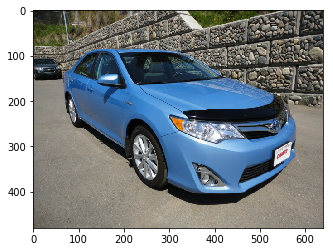

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

IMAGE_TEST_FILE = '/root/.keras/datasets/cars_test/00004.jpg' #'/content/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset/cars_test/00004.jpg' 
testimage = load_image(IMAGE_TEST_FILE)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(testimage/255.0)


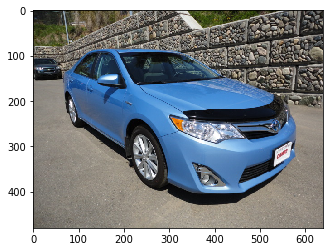

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

IMAGE_TEST_FILE = '/root/.keras/datasets/cars_test/00004.jpg' #'/content/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset/cars_test/00004.jpg' 
testimagekeras = load_image(IMAGE_TEST_FILE,True)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(testimagekeras/255.0)

**Step 1.7.1: Helper functions: resize, jitter, normalize image, crop (not used yet)**

In [0]:
def resize_image(image,height, width):
  resized_image = tf.image.resize(image, [height, width])
                                #,method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  

  return resized_image

**Optional to run this crop function, it is not used yet, put here for later use.**

In [0]:
def random_crop_image(image):  
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

**Step 1.7.2:  Normalize to the required range [-1,1] for Mobinet and [0,1] for other base models**

In [0]:
# normalizing the images to [-1, 1] range (for MobiNet model)
def normalize_image(image,startMinusOne = False):
  if startMinusOne:
    # normalizing the images to [-1, 1] range
    normalized_image = (image / 127.5) - 1
  else:  
     # normalize to [0,1] range
    normalized_image = image/ 255.0   
  
  return normalized_image

**Step 1.7.3: jitter the image**

In [0]:
@tf.function()
def random_jitter_image(image):
 
  # randomly cropping to IMG_WIDTH x IMG_HEIGHT x 3
  #cropping_image = random_crop_image(image) 
  
  jittered_image = image #cropping_image
  if tf.random.uniform(()) > 0.5:
    # random mirroring
    jittered_image = tf.image.flip_left_right(image)     

  return jittered_image

**This step is optional. Keep for later use: try preprocessing image using keras functions.**

In [0]:
from keras.preprocessing.image import ImageDataGenerator

def random_jitter_image_keras(image):
    img_gen = ImageDataGenerator()
    flip_horizontal = False
    if tf.random.uniform(()) > 0.5:
       flip_horizontal = True
    transform_parameters={'theta':20,'shear':0.1,'zx':0.98,'zy':0.98,'flip_horizontal':flip_horizontal,'brightness':0.8}
    jittered_image = img_gen.apply_transform(x=image, transform_parameters=transform_parameters)
    
    return jittered_image 

Using TensorFlow backend.


**Testing the random jitter image. This step is optional.**

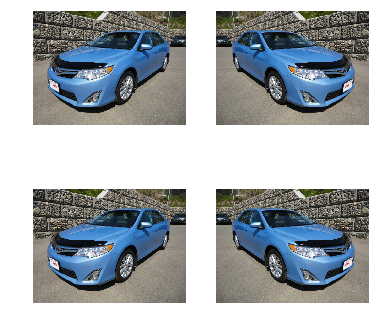

In [0]:
plt.figure(figsize=(6, 6))
for i in range(4):
  jittered_image = random_jitter_image(testimage)
  plt.subplot(2, 2, i+1)
  plt.imshow(jittered_image/255.0)
  plt.axis('off')
plt.show()

**This step is optional**

In [0]:
IMAGE_TEST_FILE = '/root/.keras/datasets/cars_test/00004.jpg' #'/content/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset/cars_test/00004.jpg' 
use_keras_funcs = True
testimage_keras = load_image(IMAGE_TEST_FILE,use_keras_funcs)
print(testimage_keras.shape)
type(testimage_keras)


(480, 640, 3)


numpy.ndarray

**This step is optional (for testing)**

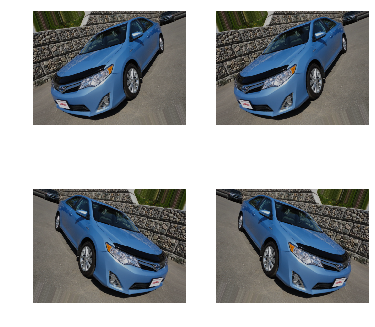

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

IMAGE_TEST_FILE = '/root/.keras/datasets/cars_test/00004.jpg' #'/content/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset/cars_test/00004.jpg' 
use_keras_funcs = True
image_keras = load_image(IMAGE_TEST_FILE,use_keras_funcs)

plt.figure(figsize=(6, 6))
for i in range(4):
  jittered_image = random_jitter_image_keras(image_keras)
  plt.subplot(2, 2, i+1)
  plt.imshow(jittered_image/255.0)
  plt.axis('off')
plt.show()


**Step 1.7.4:  Load the image for training (resize, jitter and then normalize)**

In [0]:
@tf.function()
def load_image_train(image_file):
  train_image = load_image(image_file)  
  train_image = resize_image(train_image,IMG_HEIGHT, IMG_WIDTH)
  train_image = random_jitter_image(train_image)  
  if USE_MODEL == 'xception':
    train_image = normalize_image(train_image,False) # use [0,1] range
  elif USE_MODEL == 'mobinet':
    train_image = normalize_image(train_image,True) # use [-1,1] range  
  elif USE_MODEL == 'nasnet':
    #train_image = normalize_image(train_image,True) # use [-1,1] range = Crash,OOM issue
    train_image = normalize_image(train_image,False) # use [0,1] range    
  elif USE_MODEL == 'densenet':    
    train_image = normalize_image(train_image,False) # use [0,1] range    
  else: #default
    train_image = normalize_image(train_image,False) # use [0,1] range    

    
  return train_image

**Test function load_image_train. This step is optional.**

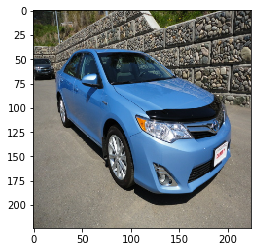

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

IMAGE_TEST_FILE = '/root/.keras/datasets/cars_test/00004.jpg'  #'/content/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset/cars_test/00004.jpg' 
train_image = load_image_train(IMAGE_TEST_FILE)
plt.figure()
plt.imshow(train_image)

**Step 1.7.5: Check if the image is in valid range (For MobiNet is [-1,1], and for XCeption is [0,1]  and for NASNet is [-1,1]**

In [0]:
IMAGE_TEST_FILE  = '/root/.keras/datasets/cars_train/04001.jpg' #'/content/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset/cars_test/00004.jpg' # 
img_test = load_image_train(IMAGE_TEST_FILE)
print(img_test.numpy().min())
print(img_test.numpy().max())

0.0
1.0


**Step 1.7.6: Define load image for testing dataset**

In [0]:
def load_image_test(image_file):
  test_image = load_image(image_file)
  test_image = resize_image(test_image,IMG_HEIGHT, IMG_WIDTH)
  test_image = normalize_image(test_image)

  return test_image

**Step 1.8: Load the labels of training images**

In [0]:
labelList = []
labelListLength = len(train_annotations_class[0,])
for i in range(0,labelListLength):
            labelList.append(tf.cast(train_annotations_class[0,i][0,0],tf.uint8).numpy())
    
imageList = []
imageListLength = len(train_images_list[0,])

for i in range(0,imageListLength):
            imageList.append(train_images_list[0,i][0]) 
    
print(len(labelList))
print("min label value=")
print(min(labelList))
print("max label value=")
print(max(labelList))

8144
min label value=
1
max label value=
196


In [0]:
test_imageList = []
test_imageListLength = len(test_images_list[0,])
 
for i in range(0,test_imageListLength):
            test_imageList.append(test_images_list[0,i][0])
    
 
print(len(test_imageList)) 
print(test_imageList[0])

8041
00001.jpg


In [0]:
TRAIN_PATH = '/root/.keras/datasets/cars_train/' #'ontent/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset/cars_train/' #

**Step 2: Prepare the Training and Validation Datasets**

**Step 2.1: Split the image into training and validation list**

In [0]:
# Reserve 1,000 samples for validation
image_validatation = imageList[-1000:]
label_validation = labelList[-1000:]
image_train = imageList[:-1000]
label_train = labelList[:-1000]
print("Number of validation set = ",len(label_validation))
print("Number of training set = ",len(label_train))

Number of validation set =  1000
Number of training set =  7144


In [0]:
type(label_validation[0])

numpy.uint8

**Step 2.2: Define training dataset**

In [0]:
ds_train = tf.data.Dataset.from_tensor_slices((image_train, label_train))
ds_train

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>

**Step 2.3: Define validation dataset**

In [0]:
ds_validation = tf.data.Dataset.from_tensor_slices((image_validatation, label_validation))
ds_validation

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>

**Define testing dataset. This step is optional, place here for use later.**

In [0]:
ds_test = tf.data.Dataset.from_tensor_slices(test_imageList)
ds_test

<TensorSliceDataset shapes: (), types: tf.string>

**Step 2.4: Define function to load the image into dataset compose of image and label**

In [0]:
# Loaded image and its label (integer)
def load_image_label(image_path, label):
  image_path = TRAIN_PATH+image_path
  #return load_image_train(image_path), label
  return load_image_train(image_path), tf.cast(label, tf.uint8)

**This step is optional. Keep here for later use**

In [0]:
#test_imageList
TEST_PATH = '/root/.keras/datasets/cars_test/' #'/content/drive/My Drive/Tensorflow/Stanford_Car_Classifier/Dataset/cars_test'  #
def load_test_image(image_path):
  image_path = TEST_PATH+image_path
  return load_image_test(image_path)

test_image_dataset = ds_test.map(load_test_image)
test_image_dataset

<MapDataset shapes: (299, 299, 3), types: tf.float32>

**Step 2.5: Define the training and validation dataset compose of image and label**

In [0]:
train_image_label_dataset = ds_train.map(load_image_label)
train_image_label_dataset

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.uint8)>

In [0]:
validation_image_label_dataset = ds_validation.map(load_image_label)
validation_image_label_dataset

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.uint8)>

**Note: Basic methods for training:**
    The data need to be:

    

*    Well shuffled
*    Batched
*    Repeat forever
*    And Batches to be available as soon as possible.


**Step 2.6: Define the Batch and Buffer Size (for shuffle and repeat)**

In [0]:
if USE_MODEL == 'nasnet': # should be small otherwise get OOM error for 12 GB RAM
  BUFFER_SIZE = 1
  BATCH_SIZE = 1
elif USE_MODEL == 'densenet': # should be small otherwise get OOM error for 12 GB RAM
  BUFFER_SIZE = 8
  BATCH_SIZE = 8
else:
  BUFFER_SIZE = 64
  BATCH_SIZE = 32

IMAGE_COUNT = 8144

print ("BUFFER_SIZE=" + str(BUFFER_SIZE))
print ("BATCH_SIZE=" + str(BATCH_SIZE))

BUFFER_SIZE=8
BATCH_SIZE=8


In [0]:
#https://www.tensorflow.org/guide/performance/datasets
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache
#If a filename is not provided, the dataset will be cached in memory.

train_ds = train_image_label_dataset.cache(filename='./cache.tf-data')
#train_ds = train_image_label_dataset.cache()
train_ds = train_image_label_dataset.apply(  
    tf.data.experimental.shuffle_and_repeat(buffer_size=BUFFER_SIZE))
train_ds = train_ds.batch(BATCH_SIZE)
#train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=BUFFER_SIZE)
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.uint8)>

In [0]:
#If a filename is not provided, the dataset will be cached in memory.
validation_ds = validation_image_label_dataset.cache(filename='./cache.tf-data-validation')
#validation_ds = validation_image_label_dataset.cache()
validation_ds = validation_image_label_dataset.apply(  
    tf.data.experimental.shuffle_and_repeat(buffer_size=BUFFER_SIZE))
validation_ds = validation_ds.batch(BATCH_SIZE)
#validation_ds = validation_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=BUFFER_SIZE)
validation_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.uint8)>

**There are a few things to note at:**
[Tensorflow tutorial:](https://www.tensorflow.org/alpha/tutorials/load_data/images)
    The order is important.
        A .shuffle after a .repeat would shuffle items across epoch boundaries (some items will be seen twice before others are seen at all).
        A .shuffle after a .batch would shuffle the order of the batches, but not shuffle the items across batches.

    We use a buffer_size the same size as the dataset for a full shuffle. Up to the dataset size, large values provide better randomization, but use more memory.

    The shuffle buffer is filled before any elements are pulled from it. So a large buffer_size may cause a delay when your Dataset is starting.

    The shuffeled dataset doesn't report the end of a dataset until the shuffle-buffer is completely empty. The Dataset is restarted by .repeat, causing another wait for the shuffle-buffer to be filled.

This last point can be addressed by using the tf.data.Dataset.apply method with the fused **tf.data.experimental.shuffle_and_repeat function**

**Step 3: Pipe the dataset to a model**
Fetch a copy of **MobileNet V2** or **XCeption** or **NASNet** or **DenseNet**.

**3.1.1: Run this part if we try NASNet as base model**

In [0]:
nasnet_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=(224, 224, 3), include_top=False, pooling='None',weights='imagenet')

# Unfreeze all layers of NASNet
#nasnet_model.trainable = False

# Let's take a look to see how many layers are in the base model
print("Number of layers in the NASNet base model: ", len(nasnet_model.layers))

# Refreeze layers until the layers we want to fine-tune
#for layer in nasnet_model.layers[:700]:
#  layer.trainable =  False

Number of layers in the NASNet base model:  769


**3.1.2: Run this part if we try MobiNet V2 as base model**

In [0]:
#https://keras.io/applications/#mobilenetv2
# (height, width, channels).
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False,pooling='None',weights='imagenet')
#mobile_net.trainable=False

# Unfreeze all layers of MobileNetV2
mobile_net.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the MobieNetV2 base model: ", len(mobile_net.layers))

# Refreeze layers until the layers we want to fine-tune
for layer in mobile_net.layers[:100]:
  layer.trainable =  False

9412608/9406464 [==============================] - 1s 0us/step
Number of layers in the MobieNetV2 base model:  155


**3.1.3: Run this part if we try XCeption as base model**

In [0]:
#Xception V1 model, with weights pre-trained on ImageNet: https://keras.io/applications/#xception
#keras.applications.xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
xception_model = tf.keras.applications.xception.Xception(include_top=False,weights='imagenet',pooling=None)

In [0]:
# Un-Freeze all layers of XCeption
xception_model.trainable = True #False

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the XCeption base model: ", len(xception_model.layers))

Number of layers in the XCeption base model:  132


In [0]:
# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the "fine_tune_at" layer
for layer in xception_model.layers[:fine_tune_at]:
  layer.trainable =  False

**3.1.4: Run if we are using DenseNet as base model**

In [0]:
densenet_model = tf.keras.applications.densenet.DenseNet201(input_shape=(224, 224, 3), include_top=False, pooling='None',weights='imagenet')

# Unfreeze all layers of DenseNet
densenet_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the DenseNet base model: ", len(densenet_model.layers))

# Refreeze layers until the layers we want to fine-tune
for layer in densenet_model.layers[:700]:
  layer.trainable =  False

Number of layers in the DenseNet base model:  707


**Checking the batch. This step is optional.**

In [0]:
#Checking the batch size:
# MobiNet V2: (32, 224, 224, 3)
# XCeption: (32, 299, 299, 3)
# NASNetMobile: (32, 224, 224, 3)

#For both MobiNet V2 and XCeption and NASNet, DenseNet
image_batch, _ = next(iter(train_ds))
print (image_batch.shape)

(32, 224, 224, 3)


In [0]:
#Run if using MobieNet V2: Checking feature map
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 7, 7, 1280)


In [0]:
#Run if using XCeption: Checking feature map
feature_map_batch = xception_model(image_batch)
print(feature_map_batch.shape)

(32, 10, 10, 2048)


In [0]:
#Run if using NASNet: Checking feature map
feature_map_batch = nasnet_model(image_batch)
print(feature_map_batch.shape)

(16, 7, 7, 1056)


In [0]:
#Run if using DenseNet: Checking feature map
feature_map_batch = densenet_model(image_batch)
print(feature_map_batch.shape)

(32, 7, 7, 1920)


**Trying with SWISH activation. This step is optional.**

In [0]:
from tensorflow.keras.layers import Layer
from tensorflow.python.keras import backend as K

class Swish(Layer):
    def __init__(self, beta, **kwargs):
        super(Swish, self).__init__(**kwargs)
        self.beta = K.cast_to_floatx(beta)

    def call(self, inputs):
        return K.sigmoid(self.beta * inputs) * inputs

    def get_config(self):
        config = {'beta': float(self.beta)}
        base_config = super(Swish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [0]:
swish_layer = Swish(beta=1) #consider which value for beta is best

**Step 4: Define the model**

**Step 4.1.1: Run this step if using NASNetMobile as base model**

In [0]:
model = tf.keras.Sequential([
  nasnet_model,     
  tf.keras.layers.BatchNormalization(),    
  tf.keras.layers.GlobalAveragePooling2D(), 
  tf.keras.layers.Dense(len(labels[0]) + 1,activation='softmax')]) 
 
  # units = len(labels[0]) = 197 : because labels for car class star from 1 to 196  

**Step 4.1.2: Run this code is using xception as base model**

In [0]:
model = tf.keras.Sequential([
  xception_model,
  tf.keras.layers.Conv2D(32, 3),
  #TEST ADDING NOISE:
  tf.keras.layers.GaussianNoise(0.1),
    
  tf.keras.layers.LeakyReLU(),
  #swish_layer,  
   
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.GlobalAveragePooling2D(),    
  #tf.keras.layers.GlobalMaxPooling2D(),
  tf.keras.layers.LeakyReLU(),
  
  tf.keras.layers.Dense(256,activation='relu'),  
  tf.keras.layers.Dropout(0.3),  
  tf.keras.layers.Dense(len(labels[0]) + 1,activation='softmax')]) 
 
  # units = len(labels[0]) = 197 : because labels for car class star from 1 to 196  

**Step 4.1.3: Run this code if using MobiNet V2 as base model**

In [0]:
#For MobiNet
model = tf.keras.Sequential([
  mobile_net,   
  #TEST ADDING NOISE:
  tf.keras.layers.GaussianNoise(0.1),
    
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.GlobalAveragePooling2D(),  
  tf.keras.layers.Dense(len(labels[0]) + 1,activation='softmax')]) #because labels for car class star from 1 to 196

**Step 4.1.4: Run this code if using DenseNet as base model**

In [0]:
model = tf.keras.Sequential([  
  densenet_model,    
  #TEST ADDING NOISE:
  tf.keras.layers.GaussianNoise(0.1),    
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.GlobalAveragePooling2D(), 
  tf.keras.layers.Dense(len(labels[0]) + 1,activation='softmax')]) 
 
  # units = len(labels[0]) = 197 : because labels for car class star from 1 to 196  

**Step 4.2: Define the learning rate and optimizer**

In [0]:
initial_learning_rate = 0.01 #0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96)

if USE_MODEL == 'xception':  
  m_optimizer = tf.keras.optimizers.RMSprop()
  print("Using RMSprop optimizer")
elif USE_MODEL == 'mobinet': 
  m_optimizer = tf.keras.optimizers.Adam()
  print("Using Adam optimizer")
elif USE_MODEL == 'nasnet':
  # NASNet mobile model: tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
  #m_optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, nesterov=True)
  m_optimizer = tf.keras.optimizers.SGD()
  print("Using SGD optimizer without learning rate scheduler")  
elif USE_MODEL == 'densenet':  
  m_optimizer = tf.keras.optimizers.RMSprop()
  print("Using RMSprop optimizer")
else: #default  
  m_optimizer = tf.keras.optimizers.Adam()
  print("Default using Adam optimizer")
  
print(USE_MODEL) 

Using RMSprop optimizer
densenet


**Step 5: Compile the model**

In [0]:
model.compile(optimizer=m_optimizer,
              loss='sparse_categorical_crossentropy', #target are integers
              metrics=["accuracy"])

In [0]:
len(model.trainable_variables)


10

**Run build only if using DenseNet as base model**

In [0]:
#Run for DenseNet
input_shape =(None,224,224,3)
model.build(input_shape)

In [0]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 7, 7, 1920)        0         
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 7, 7, 1920)        7680      
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1920)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 197)               378437    
Total params: 18,708,101
Trainable params: 664,901
Non-trainable params: 18,043,200
_________________________________________________________________


In [0]:
print("Number of train images = ",len(labelList))
steps_per_epoch=tf.math.ceil((len(labelList) -1000)/BATCH_SIZE).numpy()
print("Number of step per epoch = ",steps_per_epoch)

Number of train images =  8144
Number of step per epoch =  893.0


**This step is optional. Keep for later use**

In [0]:
TEST_PATH = '/root/.keras/datasets/cars_test/'
test_dataset = tf.data.Dataset.list_files(TEST_PATH+'*.jpg')
# shuffling: use different image for testing each epoch.
test_dataset = test_dataset.shuffle(BATCH_SIZE)
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [0]:
#!ls /root/.keras/datasets/car_ims/ | wc -l 

**Check the system capacity. This step is optional.**

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 10.7 GB  I Proc size: 3.2 GB
GPU RAM Free: 12438MB | Used: 2641MB | Util  18% | Total 15079MB


**Checking GPU. This step is optional**

In [0]:
!/opt/bin/nvidia-smi

Sun Jun  9 04:18:16 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |   4689MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#!ps -aux|grep python

root          27  0.4  0.6 406828 82636 ?        Sl   04:43   0:25 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root        4414 13.7 76.6 34764924 10227176 ?   Ssl  06:21   1:00 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-7122983f-1b8e-44fa-8fa3-cf75b02bfb60.json
root        5156  0.0  0.0  39192  6460 ?        S    06:28   0:00 /bin/bash -c ps -aux|grep python
root        5158  0.0  0.0   3196   212 ?        D    06:28   0:00 grep python


**Step 6.1: Prepare for the training**

**Write the labels to text file. We will use the label text file for mobile application.**

In [0]:
LABEL_FILE = "drive/My Drive/Tensorflow/Stanford_Car_Classifier/car_labels.txt"

remove_chars = ['[', ']', "'"] 

labels_file = open(LABEL_FILE,"w+")
labels_file.write('Unknown')
labels_file.write('\n')  

numoflabels = len(labels[0])
for i in range (0,numoflabels):
  label = str(labels[0,i])
  for j in remove_chars:
    label=label.replace(j, '')   
  labels_file.write(str(label))
  labels_file.write('\n')  
labels_file.close()

In [0]:
#CHECKPOINT_FILE = "drive/My Drive/Tensorflow/Stanford_Car_Classifier/car_model_checkpoint_nasnet_SGD_06122019.hdf5"
#CHECKPOINT_FILE = "drive/My Drive/Tensorflow/Stanford_Car_Classifier/car_model_checkpoint_mobinet_Adam_06092019.hdf5"
#CHECKPOINT_FILE = "drive/My Drive/Tensorflow/Stanford_Car_Classifier/car_model_checkpoint_mobinet_Adam_13062019.hdf5"
#CHECKPOINT_FILE = "drive/My Drive/Tensorflow/Stanford_Car_Classifier/car_model_checkpoint_xception_RMSprop_07062019.hdf5"
#CHECKPOINT_FILE = "drive/My Drive/Tensorflow/Stanford_Car_Classifier/car_model_checkpoint_xception_RMSprop_16062019.hdf5"
CHECKPOINT_FILE = "drive/My Drive/Tensorflow/Stanford_Car_Classifier/car_model_checkpoint_densenet_Adam_16062019.hdf5"

In [0]:
ls -la "drive/My Drive/Tensorflow/Stanford_Car_Classifier/"

total 1531695
-rw------- 1 root root      5462 Jun 13 16:06 car_labels.txt
-rw------- 1 root root  78641272 Jun 16 16:45 car_model_checkpoint_densenet_Adam_16062019.hdf5
-rw------- 1 root root 278443544 May 31 18:09 car_model_checkpoint.hdf5
-rw------- 1 root root  27450712 Jun  9 07:17 car_model_checkpoint_mobinet_Adam_06092019.hdf5
-rw------- 1 root root  27450472 Jun 12 17:52 car_model_checkpoint_mobinet_Adam_12062019.hdf5
-rw------- 1 root root  27451152 Jun 13 05:05 car_model_checkpoint_mobinet_Adam_13062019.hdf5
-rw------- 1 root root  27450464 Jun  8 08:01 car_model_checkpoint_mobinet_Adam_Final.hdf5
-rw------- 1 root root  27450464 Jun  6 08:44 car_model_checkpoint_mobinet_Adam.hdf5
-rw------- 1 root root  20351832 Jun  5 10:01 car_model_checkpoint_mobinet.hdf5
-rw------- 1 root root  19216896 Jun 12 06:22 car_model_checkpoint_nasnet_RMSProp_06122019.hdf5
-rw------- 1 root root  19218048 Jun 12 07:46 car_model_checkpoint_nasnet_SGD_06122019.hdf5
-rw------- 1 root root 126912484

**Step 6.2: If we already trained, then we can load the saved model and continue the training. If not trained and saved, proceed the next step 6.3**. 
**Please update the path to where the checkpoint file is saved.**

In [0]:
# Load the saved model, including weights and optimizer.
saved_model = tf.keras.models.load_model('drive/My Drive/Tensorflow/Stanford_Car_Classifier/car_model_checkpoint_mobinet_Adam_12062019.hdf5')
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 7, 7, 1280)        5120      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 197)               252357    
Total params: 2,515,461
Trainable params: 2,117,509
Non-trainable params: 397,952
_________________________________________________________________


In [0]:
# Load model xception saved: car_model_checkpoint_xception_RMSprop_07062019.hdf5
saved_model = tf.keras.models.load_model('drive/My Drive/Tensorflow/Stanford_Car_Classifier/car_model_checkpoint_xception_RMSprop_07062019.hdf5')

In [0]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, None, None, 2048)  20861480  
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 32)    589856    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, None, None, 32)    0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, None, None, 32)    128       
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               8

**For testing if load saved model. This step is optional**

In [0]:
# Check the loaded model
test_loaded_ds = validation_image_label_dataset.batch(10)
lossList, accList = saved_model.evaluate(test_loaded_ds) 
accList

100/100 [==============================] - 10s 102ms/step - loss: 1.4661 - accuracy: 0.8030


0.803

**Step 6.3: Call back function to save checkpoint, and write log for tensorboard**

**Step 6.3.1: Callback to save the model checkpoint**

In [0]:
callbacks_save = tf.keras.callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_FILE,
        # Path where to save the model
        # Overwrite the current checkpoint if and only if
        # the "val_accuracy" score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1)

**Step 6.3.2: Callback to write the log for TensorBoard. Please specify the log_dir location**

In [0]:
import datetime

# Load the TensorBoard notebook extension
#log_dir="drive/My Drive/Tensorflow/Stanford_Car_Classifier/Log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_exception"
log_dir="drive/My Drive/Tensorflow/Stanford_Car_Classifier/Log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_densenet"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

**Step 7: Training. Please specify the number of epochs for the training**

In [0]:
# Training
train_history = model.fit(train_ds,validation_data=validation_ds,epochs=100,callbacks=[tensorboard_callback,callbacks_save])

In [0]:
!ls -la 'drive/My Drive/Tensorflow/Stanford_Car_Classifier/Log/'

total 32
drwx------ 2 root root 4096 Jun 16 07:19 20190616-071855_exception
drwx------ 2 root root 4096 Jun 16 12:43 20190616-124304_densenet
drwx------ 2 root root 4096 Jun 16 13:02 20190616-130250_densenet
drwx------ 2 root root 4096 Jun 16 13:10 20190616-131013_densenet
drwx------ 2 root root 4096 Jun 16 13:20 20190616-131959_densenet
drwx------ 2 root root 4096 Jun 16 13:30 20190616-133004_densenet
drwx------ 2 root root 4096 Jun 16 13:43 20190616-134310_densenet
drwx------ 5 root root 4096 Jun 16 13:45 20190616-134548_densenet


**Step 8: Load the TensorBoard to view the training performance. Please update the log dir to the location where you saved the log event files (Step 6.3.2)**

In [0]:
%load_ext tensorboard.notebook

In [0]:
#%tensorboard --logdir 'drive/My Drive/Tensorflow/Stanford_Car_Classifier/Log/20190616-071855_exception/'
%tensorboard --logdir 'drive/My Drive/Tensorflow/Stanford_Car_Classifier/Log/20190616-134548_densenet/'